In [62]:
# Standard library imports
import argparse
import re
import warnings

# Third-party libraries
import contractions
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC

# NLTK downloads
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

True

## Load data

In [21]:
def load_data(filepath):
    data = pd.read_csv(filepath, sep='\t', names=['title', 'from', 'genre', 'director', 'plot'])
    return data

In [22]:
data = load_data('train.txt')
data.head()

,title,from,genre,director,plot
0,Ela Cheppanu,Telugu,romance,Ramana,Sekhar (Tarun) is a graduate from IIM and work...
1,A Nightmare on Elm Street,American,horror,Samuel Bayer,Kris Fowles (Katie Cassidy) goes to the Spring...
2,American Gothic,American,horror,John Hough,Cynthia is traumatized by the death of her bab...
3,Gang,Bollywood,crime,Mazhar Khan,"Four friends, Gangu (Jackie Shroff), Abdul (Na..."
4,Intimate Relations,British,drama,Charles Frank,Crisis in a middle-class family when the son f...


# Clean the text

In [32]:
# Clean the text
def clean_text(text):
    # Check if the text is a non-empty string
    if not isinstance(text, str) or not text.strip():
        return ''
    
    # Skip applying contractions if the text is too long or complex
    if len(text) > 500:  # Threshold to skip contraction expansion for long texts
        return text
    
    # Try expanding contractions safely
    try:
        text = contractions.fix(text)
    except Exception as e:
        print(f"Error expanding contractions: {e}, for text: {text[:100]}...")  # Only print the first 100 characters
        return text  # Return the original text if expansion fails
    
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    return text

# Function to convert nltk POS tag to wordnet POS tag

In [24]:
# Function to convert nltk POS tag to wordnet POS tag
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ  # Adjective
    elif tag.startswith('V'):
        return wordnet.VERB  # Verb
    elif tag.startswith('N'):
        return wordnet.NOUN  # Noun
    elif tag.startswith('R'):
        return wordnet.ADV  # Adverb
    else:
        return wordnet.NOUN  # Default to noun

# Lemmatize the text

Removing stop words

In [33]:
# Lemmatize the text removing stop words
stop_words = set(stopwords.words('english'))

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    # Clean the text
    text = clean_text(text)
    # Tokenize the text
    tokens = nltk.word_tokenize(text.lower())
    # Remove stop words and non-alphabetic tokens
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    # Perform POS tagging
    tagged_tokens = nltk.pos_tag(tokens)
    # Lemmatize each token using the POS tag
    lemmatized_tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in tagged_tokens]
    return ' '.join(lemmatized_tokens)


Not removing stop words

In [44]:
# Lemmatize the text not removing stop words
def lemmatize_text_keep_sw(text):
    lemmatizer = WordNetLemmatizer()
    # Clean the text
    text = clean_text(text)
    # Tokenize the text
    tokens = nltk.word_tokenize(text.lower())
    # Remove stop words and non-alphabetic tokens
    tokens = [word for word in tokens if word.isalpha()]
    # Perform POS tagging
    tagged_tokens = nltk.pos_tag(tokens)
    # Lemmatize each token using the POS tag
    lemmatized_tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in tagged_tokens]
    return ' '.join(lemmatized_tokens)


# Preprocess the data

Without stop words (stop words removed)

In [34]:
# Preprocess the data without stop words
def preprocess_data(data, lemmatize, combine_fields):
    # Extract relevant columns (plot, combine_fields, genre)
    selected_fields = ['plot'] + combine_fields
    if 'genre' in data.columns:
        selected_fields.append('genre')
    data = data[selected_fields].copy()
    
    # Handle missing values: drop rows with missing 'plot', fill missing combine_fields with ''
    data.dropna(subset=['plot'], inplace=True)  # Ensure 'plot' is not NaN
    for field in combine_fields:
        data[field] = data[field].fillna('')  # Replace NaN in combine_fields with empty strings

    # Combine plot and other specified fields into a single feature
    data['combined_text'] = data['plot']
    for field in combine_fields:
        data['combined_text'] += ' ' + data[field]

    # Apply lemmatization if specified
    if lemmatize:
        data['combined_text'] = data['combined_text'].apply(lemmatize_text)
    else:
        # Clean the text anyway
        data['combined_text'] = data['combined_text'].apply(clean_text)

    return data

With stop words

In [ ]:
# Preprocess the data with stop words
def preprocess_data_keep_sw(data, lemmatize, combine_fields):
    # Extract relevant columns (plot, combine_fields, genre)
    selected_fields = ['plot'] + combine_fields
    if 'genre' in data.columns:
        selected_fields.append('genre')
    data = data[selected_fields].copy()
    
    # Handle missing values: drop rows with missing 'plot', fill missing combine_fields with ''
    data.dropna(subset=['plot'], inplace=True)  # Ensure 'plot' is not NaN
    for field in combine_fields:
        data[field] = data[field].fillna('')  # Replace NaN in combine_fields with empty strings

    # Combine plot and other specified fields into a single feature
    data['combined_text'] = data['plot']
    for field in combine_fields:
        data['combined_text'] += ' ' + data[field]

    # Apply lemmatization if specified
    if lemmatize:
        data['combined_text'] = data['combined_text'].apply(lemmatize_text_keep_sw)
    else:
        # Clean the text anyway
        data['combined_text'] = data['combined_text'].apply(clean_text)

    return data

In [46]:
combine_fields = ['from', 'director', 'title']
data_removed = preprocess_data(data, True, combine_fields)
data_not_removed = preprocess_data_keep_sw(data, True, combine_fields)

# Split data into training and test sets

In [47]:
# Split data into training and test sets
def split_data(data):
    X = data['combined_text']
    y = data['genre']
    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.1, random_state=42, stratify=y_encoded)
    return X_train, X_test, y_train, y_test, label_encoder


In [87]:
X_train_removed, X_test_removed, y_train_removed, y_test_removed, label_encoder_removed = split_data(data_removed)

X_train_series_removed = pd.Series(X_train_removed)
y_train_series_removed = pd.Series(y_train_removed)

In [88]:
X_train_not_removed, X_test_not_removed, y_train_not_removed, y_test_not_removed, label_encoder_not_removed = split_data(data_not_removed)

X_train_series_not_removed = pd.Series(X_train_not_removed)
y_train_series_not_removed = pd.Series(y_train_not_removed)

# Basic Statistics

Without stop words

In [89]:
# Length analysis (counting words)
word_count_remove = X_train_series_removed.apply(lambda x: len(x.split()))
word_count_summary_remove = word_count_remove.describe()


# Genre distribution
genre_counts_remove = y_train_series_removed.value_counts()


print(f'''\n{'-'*60}
Word Count Summary Statistics :\n{word_count_summary_remove}\n{'-'*60}
Word Count Distribution by Genre: per genre :\n{genre_counts_remove}
''')


------------------------------------------------------------
Word Count Summary Statistics :
count    7236.000000
mean      207.007324
std       169.177456
min         7.000000
25%        66.000000
50%       159.000000
75%       326.000000
max      1610.000000
Name: combined_text, dtype: float64
------------------------------------------------------------
Word Count Distribution by Genre: per genre :
4    1508
2    1074
5     997
0     953
6     797
8     746
3     487
1     481
7     193
Name: count, dtype: int64



With stop words

In [90]:
# Length analysis (counting words)
word_count_not_remove = X_train_series_not_removed.apply(lambda x: len(x.split()))
word_count_summary_not_remove = word_count_remove.describe()


# Genre distribution
genre_counts_not_remove = y_train_series_not_removed.value_counts()


print(f'''\n{'-'*60}
Word Count Summary Statistics :\n{word_count_summary_not_remove}\n{'-'*60}
Word Count Distribution by Genre: per genre :\n{genre_counts_not_remove}
''')


------------------------------------------------------------
Word Count Summary Statistics :
count    7236.000000
mean      207.007324
std       169.177456
min         7.000000
25%        66.000000
50%       159.000000
75%       326.000000
max      1610.000000
Name: combined_text, dtype: float64
------------------------------------------------------------
Word Count Distribution by Genre: per genre :
4    1508
2    1074
5     997
0     953
6     797
8     746
3     487
1     481
7     193
Name: count, dtype: int64



# Plotting

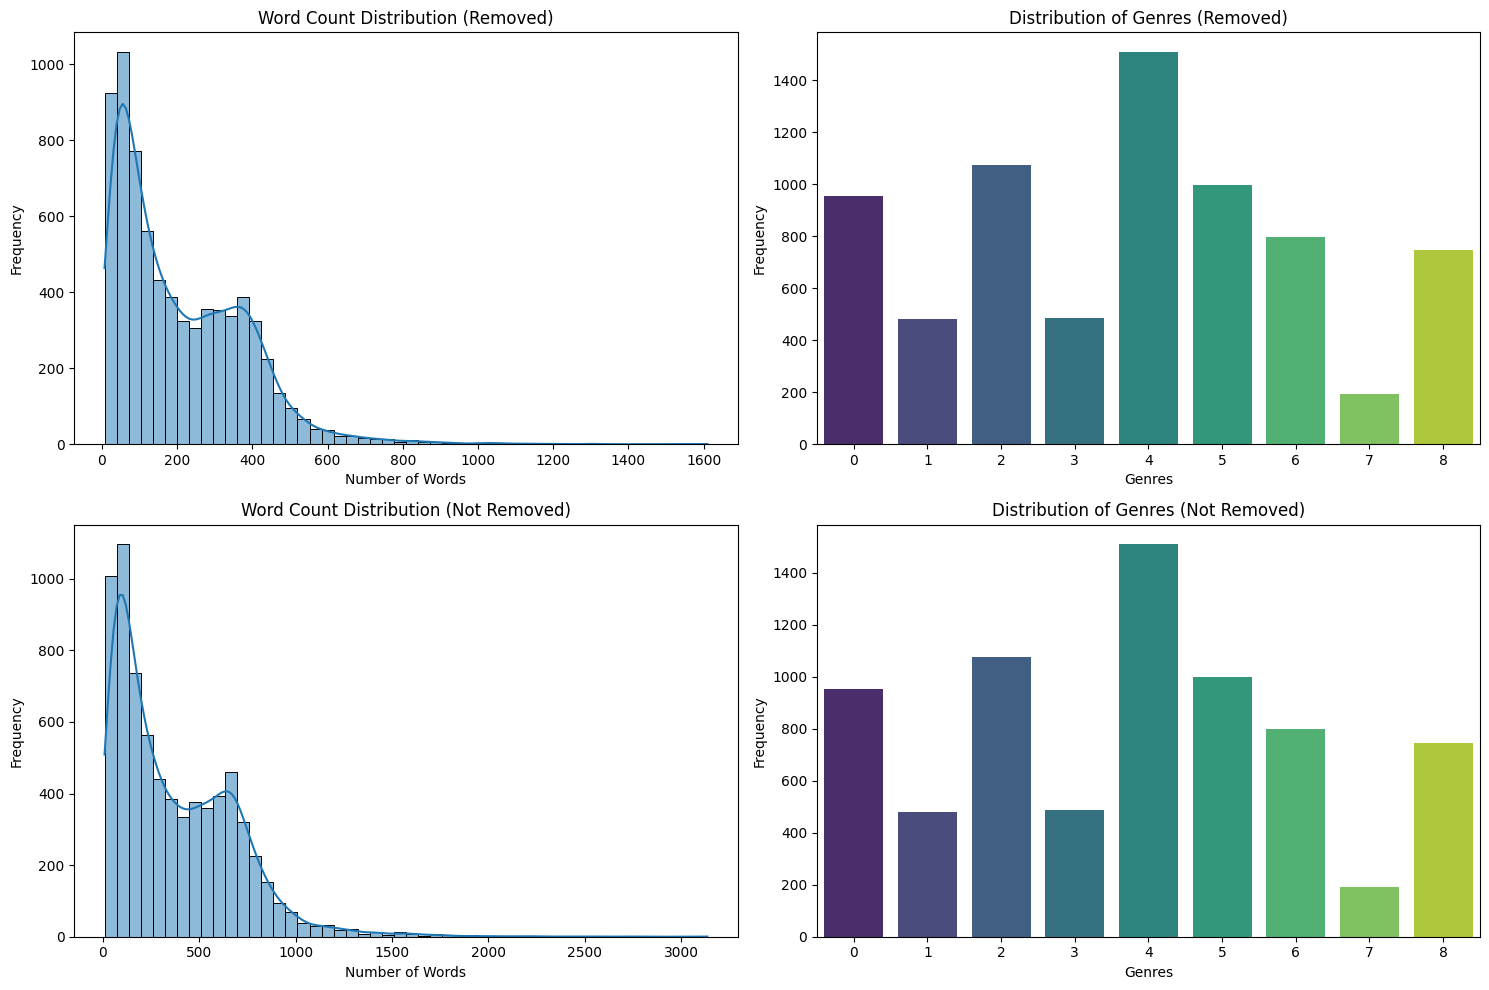

In [92]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming word_count_remove, word_count_not_remove, genre_counts_remove, and genre_counts_not_remove are defined appropriately
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)

    # Create a figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))  # Adjusted height for better layout

    # Word count distribution for word_count_remove
    sns.histplot(word_count_remove, bins=50, ax=axes[0, 0], kde=True)
    axes[0, 0].set_title('Word Count Distribution (Removed)')
    axes[0, 0].set_xlabel('Number of Words')
    axes[0, 0].set_ylabel('Frequency')

    # Distribution of the target variable (genre) for genre_counts_remove
    sns.barplot(x=genre_counts_remove.index, y=genre_counts_remove.values, ax=axes[0, 1], palette='viridis')
    axes[0, 1].set_title('Distribution of Genres (Removed)')
    axes[0, 1].set_xlabel('Genres')
    axes[0, 1].set_ylabel('Frequency')

    # Word count distribution for word_count_not_remove
    sns.histplot(word_count_not_remove, bins=50, ax=axes[1, 0], kde=True)
    axes[1, 0].set_title('Word Count Distribution (Not Removed)')
    axes[1, 0].set_xlabel('Number of Words')
    axes[1, 0].set_ylabel('Frequency')

    # Distribution of the target variable (genre) for genre_counts_not_remove
    sns.barplot(x=genre_counts_not_remove.index, y=genre_counts_not_remove.values, ax=axes[1, 1], palette='viridis')
    axes[1, 1].set_title('Distribution of Genres (Not Removed)')
    axes[1, 1].set_xlabel('Genres')
    axes[1, 1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()


In [93]:
# CountVectorizer to create a document-term matrix for stop words
vectorizer = CountVectorizer(vocabulary=stop_words, binary=True)  # Count presence
X = vectorizer.fit_transform(X_train_series_not_removed)  # Transform the title-plot feature

# Compute document frequencies
doc_freq = X.sum(axis=0) / X.shape[0]  # Fraction of documents (observations) containing each stop word

# Sort stop words by document frequency.
stop_word_df = pd.DataFrame({
    'stop_word': vectorizer.get_feature_names_out(),
    'doc_frequency': doc_freq.A1
}).sort_values(by='doc_frequency', ascending=False)

# Set a threshold for significant stop words
def threshold_stop_word_df(stop_word_df, threshold=0.82):   # Default: appearing in 82% of observations
  return stop_word_df[stop_word_df['doc_frequency'] >= threshold]

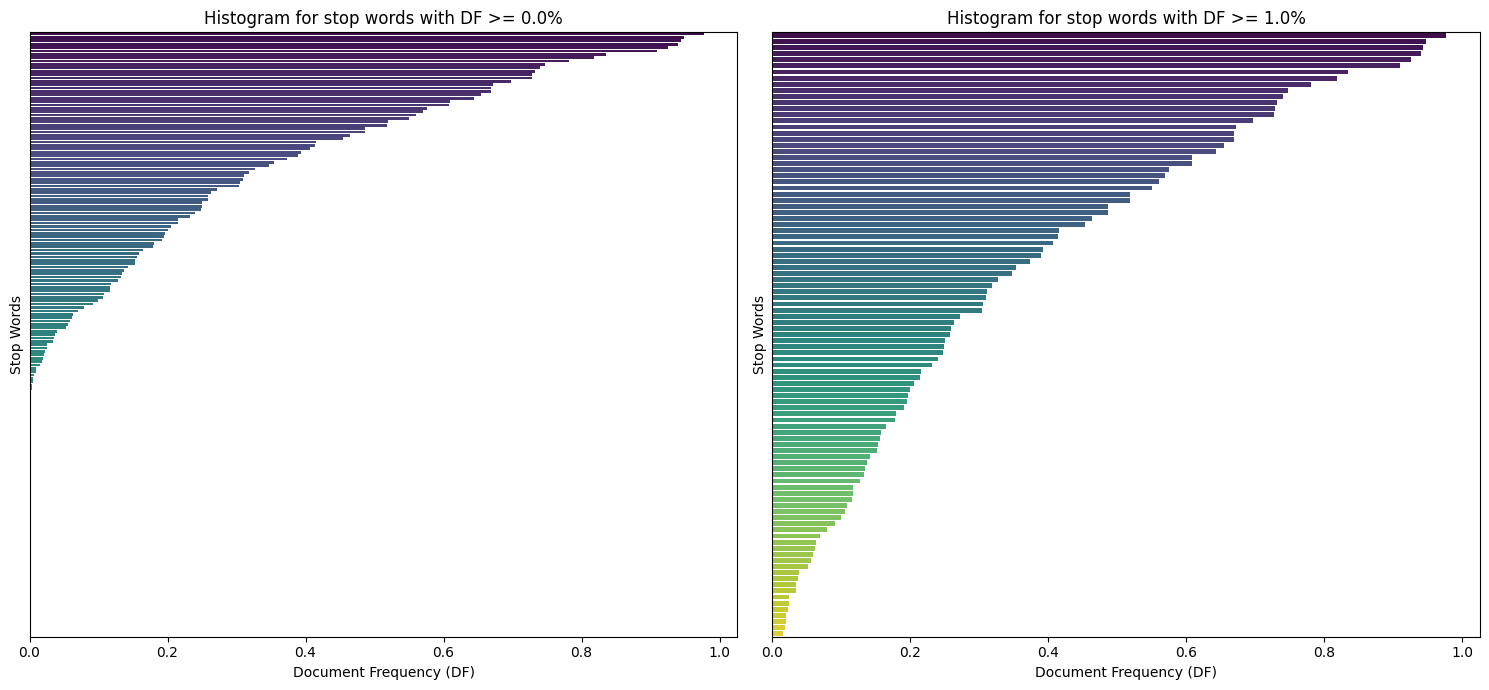

In [94]:
# Stop words document frequency (DF)
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    plt.figure(figsize=(15, 7))

    # Stop words appearing in >= 0 observations
    threshold = 0.0
    plt.subplot(1, 2, 1)
    sns.barplot(x='doc_frequency', y='stop_word', data=threshold_stop_word_df(stop_word_df, threshold), palette='viridis')
    plt.title(f'Histogram for stop words with DF >= {threshold*100}%')
    plt.xlabel('Document Frequency (DF)')
    plt.ylabel('Stop Words')
    plt.yticks([])

    # Stop words appearing in >= 1% observations
    threshold = 0.01
    top_stop_words = stop_word_df[stop_word_df['doc_frequency'] >= threshold]
    plt.subplot(1, 2, 2)
    sns.barplot(x='doc_frequency', y='stop_word', data=threshold_stop_word_df(stop_word_df, threshold), palette='viridis')
    plt.title(f'Histogram for stop words with DF >= {threshold*100}%')
    plt.xlabel('Document Frequency (DF)')
    plt.ylabel('Stop Words')
    plt.yticks([])

    plt.tight_layout()
    plt.show()

In [98]:
threshold = 0.5   # choose stop word' DF threshold
stop_words_filtered = threshold_stop_word_df(stop_word_df, threshold)['stop_word'].tolist()
print(stop_words_filtered)

threshold = int(threshold*100)

# Save the stop words to a file
file = open(f'stop_words{threshold}.txt','w')
for stop_word in stop_words_filtered:
	file.write(stop_word+",")
file.close()

['the', 'to', 'and', 'be', 'of', 'in', 'his', 'with', 'he', 'for', 'by', 'have', 'that', 'who', 'on', 'but', 'him', 'an', 'from', 'her', 'at', 'when', 'they', 'after', 'it', 'their', 'she', 'out']


# Feature extraction using count and TF-IDF vectorizers

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

max_features = 10000
ngram_range = (1, 3)

count_vectorizer = CountVectorizer(
    max_features=max_features,
    ngram_range=ngram_range,
    min_df=5)

tfidf_vectorizer = TfidfVectorizer(
    max_features=max_features,
    ngram_range=ngram_range,
    sublinear_tf=True,
    norm='l2',
    min_df=5
    )


# Feature extraction function
def extract_features(X_train, X_test, vectorizer, max_features, ngram_range):

    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)
    return X_train_vec, X_test_vec


X_train_count, X_test_count = extract_features(X_train, X_test, count_vectorizer, max_features, ngram_range)
X_train_tfidf, X_test_tfidf = extract_features(X_train, X_test, tfidf_vectorizer, max_features, ngram_range)

# Train SVM with hyperparameter tuning

In [ ]:
#kernels = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']

In [28]:
def train_svm(X_train_vec, y_train):
    param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['linear'],
        'class_weight': ['balanced', None]
    }
    grid_search = GridSearchCV(SVC(), param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train_vec, y_train)
    best_model = grid_search.best_estimator_
    print(f"Best SVM Parameters: {grid_search.best_params_}")
    return best_model


In [ ]:
svm_count = train_svm(X_train_count, y_train)
svm_tfidf = train_svm(X_train_tfidf, y_train)

KeyboardInterrupt: 

In [ ]:
from collections import defaultdict

def train_ngram_model(corpus, n):
    model = defaultdict(lambda: defaultdict(lambda: 0))

    # Count n-grams
    for sentence in corpus:
        tokens = sentence.split()
        for i in range(len(tokens) - n + 1):
            ngram = tuple(tokens[i:i+n-1])
            next_word = tokens[i+n-1]
            model[ngram][next_word] += 1

    return model

def absolute_discounting(model, ngram, discount=0.75):
    total_count = sum(model[ngram].values())
    adjusted_count = max(total_count - discount, 0)
    return adjusted_count / total_count if total_count > 0 else 0

def generate_probability_distribution(model, discount=0.75):
    probabilities = defaultdict(lambda: defaultdict(lambda: 0))
    for ngram in model:
        total_count = sum(model[ngram].values())
        for next_word in model[ngram]:
            probabilities[ngram][next_word] = (model[ngram][next_word] - discount) / total_count
    return probabilities

def train_MultinomialNB(X_train_tfidf, y_train):
    param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['linear'],
        'class_weight': ['balanced', None]
    }
    grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train_tfidf, y_train)
    best_model = grid_search.best_estimator_
    print(f"Best SVM Parameters: {grid_search.best_params_}")
    return best_model


# Evaluate the model

In [ ]:
def evaluate_model(model, X_test_tfidf, y_test):
    predictions = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, predictions)
    report = classification_report(y_test, predictions)
    cm = confusion_matrix(y_test, predictions)
    return accuracy, cm, report


# Save the best model

In [ ]:
def save_model(model, vectorizer, label_encoder, model_path, vectorizer_path, label_encoder_path):
    dump(model, model_path)
    dump(vectorizer, vectorizer_path)
    dump(label_encoder, label_encoder_path)


In [ ]:
model_path='svm_count.pkl'
vectorizer_path='count_vectorizer.pkl'
label_encoder_path='count_label_encoder.pkl'
save_model(svm_count, count_vectorizer, label_encoder, model_path, vectorizer_path, label_encoder_path)

model_path='svm_tfidf.pkl'
vectorizer_path='tfidf_vectorizer.pkl'
label_encoder_path='tfidflabel_encoder.pkl'
save_model(svm_tfidf, tfidf_vectorizer, label_encoder, model_path, vectorizer_path, label_encoder_path)

# Load the model and vectorizer

In [ ]:
def load_model(model_path, vectorizer_path, label_encoder_path):
    model = load(model_path)
    vectorizer = load(vectorizer_path)
    label_encoder = load(label_encoder_path)
    return model, vectorizer, label_encoder


# Predict the genre for new movie plots

In [ ]:
def predict_genre(model, vectorizer, label_encoder, input_file, output_file, lemmatize, combine_fields):
    data = pd.read_csv(input_file, sep='\t', names=['title', 'from', 'director', 'plot'])
    data = preprocess_data(data, lemmatize, combine_fields)
    plots = data['combined_text']
    plot_vectors = vectorizer.transform(plots)
    predicted_genres_encoded = model.predict(plot_vectors)
    predicted_genres = label_encoder.inverse_transform(predicted_genres_encoded)

    # Save the results to a file
    data['genre'] = predicted_genres
    data[['title', 'from', 'director', 'plot', 'genre']].to_csv(output_file, sep='\t', index=False)


# Main function to run the program

In [ ]:
data

,plot,from,director,title,genre,combined_text


In [ ]:
if __name__ == '__main__':

    train_filepath = 'train.txt'
    #test_filepath = 'test_no_labels.txt'
    #results_filepath = 'results.txt'
    max_features = 10000
    ngram_range = '1,3'
    lemma = False
    combine_fields = 'from,director,title'

    # Parse ngram_range as a tuple
    ngram_range = tuple(map(int, ngram_range.split(',')))

    # Parse combine_fields as a list of field names
    combine_fields = combine_fields.split(',')

    """# Convert the stop words string into a list (if not using 'english')
    if stop_words != 'english':
        stop_words = stop_words.split(',')
    else:
        stop_words = 'english'"""

    # Load and preprocess the data
    data = load_data(train_filepath)
    data = preprocess_data(data, lemma, combine_fields)

    # Analyze class distribution
    print("Class distribution:")
    print(data['genre'].value_counts())

    # Split the data into training and test sets
    X_train, X_validation, X_test, y_train, y_validation, y_test, label_encoder = split_data(data)

    # Train SVM with hyperparameter tuning
    best_svm_model, best_threshold, vectorizer = grid_search_and_train_svm(X_train, X_validation, y_train, y_validation, max_features, ngram_range, cv=5, scoring='accuracy')



Class distribution:
genre
drama        1676
comedy       1193
horror       1108
action       1059
romance       886
western       829
crime         541
animation     535
sci-fi        214
Name: count, dtype: int64
Threshold: 0.10, Validation Accuracy: 0.7113, Best SVM Parameters: {'C': 1, 'class_weight': 'balanced', 'kernel': 'linear'}
Threshold: 0.20, Validation Accuracy: 0.7141, Best SVM Parameters: {'C': 1, 'class_weight': 'balanced', 'kernel': 'linear'}
Threshold: 0.30, Validation Accuracy: 0.7169, Best SVM Parameters: {'C': 1, 'class_weight': 'balanced', 'kernel': 'linear'}
Threshold: 0.40, Validation Accuracy: 0.7182, Best SVM Parameters: {'C': 1, 'class_weight': 'balanced', 'kernel': 'linear'}
Threshold: 0.50, Validation Accuracy: 0.7141, Best SVM Parameters: {'C': 1, 'class_weight': 'balanced', 'kernel': 'linear'}
Threshold: 0.60, Validation Accuracy: 0.7072, Best SVM Parameters: {'C': 1, 'class_weight': 'balanced', 'kernel': 'linear'}


In [ ]:
  # Evaluate model
    svm_accuracy, svm_cm, svm_report = evaluate_model(best_svm_model, X_test_tfidf, y_test)
    print(f"Optimized SVM Accuracy: {svm_accuracy * 100:.2f}%")
    print("Classification Report:")
    print(svm_report)

    # Cross-validation
    cv_scores = cross_val_score(best_svm_model, X_train_tfidf, y_train, cv=5, scoring='accuracy')
    print(f"Cross-validation Accuracy: {cv_scores.mean() * 100:.2f}% (+/- {cv_scores.std() * 100:.2f}%)")

    # Save the best model
    save_model(best_svm_model, vectorizer, label_encoder, 'best_model.pkl', 'vectorizer.pkl', 'label_encoder.pkl')

    # Predict genres for the test file and save results
    predict_genre(best_svm_model, vectorizer, label_encoder, test_filepath, results_filepath, lemma, combine_fields)


In [ ]:
def stop_words_frequency(data):
  # CountVectorizer to create a document-term matrix for stop words
  stop_words = set(stopwords.words('english'))  # English stop words
  vectorizer = CountVectorizer(vocabulary=stop_words, binary=True)  # Count presence
  X = vectorizer.fit_transform(data['title_plot'])  # Transform the title-plot feature

  # Compute document frequencies
  doc_freq = X.sum(axis=0) / X.shape[0]  # Fraction of documents (observations) containing each stop word

  # Sort stop words by document frequency.
  stop_word_df = pd.DataFrame({
      'stop_word': vectorizer.get_feature_names_out(),
      'doc_frequency': doc_freq.A1
  }).sort_values(by='doc_frequency', ascending=False)

  return stop_word_df

def list_stop_words(df_stop_words, threshold):
  # Filter stop words by a document frequency threshold
  top_stop_words = df_stop_words[df_stop_words['doc_frequency'] >= threshold]
  return list(top_stop_words['stop_word'].values)

# Function to remove stop words
def filter_tokens(tokens, top_stop_words):
    return [word for word in tokens if word not in top_stop_words]

def remove_stop_words(data, top_stop_words):
  return data['words'].apply(filter_tokens, args=(top_stop_words,))

In [ ]:
stop_words = list_stop_words(stop_word_df, 0.5)
remove_stop_words(X_train, stop_words)

KeyError: 'words'

In [ ]:
stop_word_df = stop_words_frequency(data)
stop_word_df.head()

,stop_word,doc_frequency
129,the,0.976993
141,to,0.948016
10,and,0.942420
17,be,0.940182
98,of,0.925631
